In [1]:
import pandas as pd
import seaborn as sns

In [2]:
def get_files(dir, prefix):

    all_files = {}
    
    # Importing kracken output
    kracken_header = ['Classified/Unclassified', 'Sequence', 'Taxid', 'length', 'K-mer loc']
    kraken_output = pd.read_csv(dir+prefix+'_out.tsv', sep = '\t', names = kracken_header)
    all_files['kout'] = kraken_output

    # Importing kracken report
    kracken_header = ['pct_frag', 'number_frags_clade', 'number_frags_taxon', 'rank_code', 'Taxid', 'scientific_name']
    kraken_report = pd.read_csv(dir+prefix+'_report.tsv', sep = '\t', names = kracken_header)
    all_files['kreport'] = kraken_report

    # Importing mef
    mef = pd.read_csv(dir+prefix+'_mef_out.csv', comment='#')
    all_files['mef'] = mef

    # Importing card
    card = pd.read_csv(dir+prefix+'_out.txt', sep = '\t')
    card = card[card.Nudged != True]
    all_files['card'] = card

    # Import amrfinder
    amrfinder = pd.read_csv(dir+prefix+'_AMRFinder.tsv', sep = '\t')
    all_files['amrfinder'] = amrfinder

    # Import resfinder
    resfinder = pd.read_csv(dir+'Resfinder_results_tab.txt', sep = '\t')
    all_files['resfinder'] = resfinder

    return all_files

In [3]:
def contig_seqname2k2(name):
    if name[0] in ['P','C']:
        rename = "_".join(name.split('_')[2:])
    else:
        rename = "_".join(name.split('_')[1:])
    return rename
def contig_card_seqname2k2(name):
    if name[0] in ['P','C']:
        if len(name.split('_')) == 5:
            rename = "_".join(name.split('_')[2:-1])
        else:
            rename = "_".join(name.split('_')[2:])
    else:
        if len(name.split('_')) == 4:
            rename = "_".join(name.split('_')[1:-1])
        else:
            rename = "_".join(name.split('_')[1:])
    return rename

def contig_card_seqname2plasmer(name):
    if name[0] in ['P','C']:
        if len(name.split('_')) == 5:
            rename = "_".join(name.split('_')[:-1])
        else:
            rename = name
    else:
        if len(name.split('_')) == 4:
            rename = "_".join(name.split('_')[:-1])
        else:
            rename = name
    return rename

In [4]:
def card_meta_df(dir,prefix):

    all_files = get_files(dir, prefix)
    
    taxid_ls = []
    id_name_ls = []
    id_level_ls = []
    k2_name_ls = []
    plas_name_ls = []
    plasmer_class = []
    mef_name_ls = []
    mef_type_ls = []
    mef_start_ls = []
    mef_stop_ls = []
    
    for index, row in all_files['card'].iterrows():
        k2_name = contig_card_seqname2k2(row['Contig'])
        k2_name_ls.append(k2_name)
        taxid = all_files['kout'].loc[all_files['kout']['Sequence'] == k2_name]['Taxid'].values[0]
        taxid_ls.append(taxid)
        
        id_name = all_files['kreport'].loc[all_files['kreport']['Taxid'] == taxid]['scientific_name'].values[0]
        id_name_break = id_name.split()
        formated_name_ls = []
        for strs in id_name_break:
            if len(strs) > 0:
                formated_name_ls.append(strs)
        formated_name = " ".join(formated_name_ls)
        id_name_ls.append(formated_name)
        
        id_level = all_files['kreport'].loc[all_files['kreport']['Taxid'] == taxid]['rank_code'].values[0]
        id_level_ls.append(id_level)
    
        plas_name = contig_card_seqname2plasmer(row['Contig'])
        plas_name_ls.append(plas_name)

        mef_subset = all_files['mef'].loc[all_files['mef']['contig'] == plas_name].values
        
        if len(mef_subset) > 0:
            mef_name_ls.append(all_files['mef'].loc[all_files['mef']['contig'] == plas_name]['name'].values[0])
            mef_type_ls.append(all_files['mef'].loc[all_files['mef']['contig'] == plas_name]['type'].values[0])
            mef_start_ls.append(all_files['mef'].loc[all_files['mef']['contig'] == plas_name]['start'].values[0])
            mef_stop_ls.append(all_files['mef'].loc[all_files['mef']['contig'] == plas_name]['end'].values[0])
            print('Mobile Element Found in sample ' + prefix)
            
        else:
            mef_name_ls.append('na')
            mef_type_ls.append('na')
            mef_start_ls.append('na')
            mef_stop_ls.append('na')
    
        if plas_name[0] == 'P':
            plasmer_class.append('P')
        elif plas_name[0] == 'C':
            plasmer_class.append('C')
        else:
            plasmer_class.append('U')
    
    meta_card = all_files['card']
    meta_card['Plasmer Class'] = plasmer_class
    meta_card['TaxID'] = taxid_ls
    meta_card['TaxID Level'] = id_level_ls
    meta_card['TaxID Name'] = id_name_ls
    meta_card['MEF_Name'] = mef_name_ls
    meta_card['MEF_Type'] = mef_type_ls
    meta_card['MEF_Start'] = mef_start_ls
    meta_card['MEF_Stop'] = mef_stop_ls
    meta_card['Kraken2 Seq Name'] = k2_name_ls
    meta_card['Plasmer Seq Name'] = plas_name_ls

    return meta_card

In [5]:
data_files = [['combo_it_all/Urban_1/','urban_1'],['combo_it_all/Urban_2/','urban_2'],['combo_it_all/Urban_3/','urban_3'],['combo_it_all/Urban_4/','urban_4'],['combo_it_all/Rural_1/','rural_1'],['combo_it_all/Rural_2/','rural_2'],['combo_it_all/Rural_3/','rural_3'],['combo_it_all/Rural_4/','rural_4']]

card_meta_files = {}

for files in data_files:
    card_meta = card_meta_df(files[0],files[1])
    save_name = files[1] + '_meta_card.csv'
    card_meta.to_csv(save_name)
    card_meta_files[files[1]] = card_meta

Mobile Element Found in sample urban_2


In [6]:
def amrfinder_meta_df(dir,prefix):

    all_files = get_files(dir, prefix)
    
    taxid_ls = []
    id_name_ls = []
    id_level_ls = []
    k2_name_ls = []
    plas_name_ls = []
    plasmer_class = []
    mef_name_ls = []
    mef_type_ls = []
    mef_start_ls = []
    mef_stop_ls = []
    
    for index, row in all_files['amrfinder'].iterrows():
        k2_name = contig_seqname2k2(row['Contig id'])
        k2_name_ls.append(k2_name)
        taxid = all_files['kout'].loc[all_files['kout']['Sequence'] == k2_name]['Taxid'].values[0]
        taxid_ls.append(taxid)
        
        id_name = all_files['kreport'].loc[all_files['kreport']['Taxid'] == taxid]['scientific_name'].values[0]
        id_name_break = id_name.split()
        formated_name_ls = []
        for strs in id_name_break:
            if len(strs) > 0:
                formated_name_ls.append(strs)
        formated_name = " ".join(formated_name_ls)
        id_name_ls.append(formated_name)
        
        id_level = all_files['kreport'].loc[all_files['kreport']['Taxid'] == taxid]['rank_code'].values[0]
        id_level_ls.append(id_level)
    
        plas_name = row['Contig id']
        plas_name_ls.append(plas_name)

        mef_subset = all_files['mef'].loc[all_files['mef']['contig'] == plas_name].values
        
        if len(mef_subset) > 0:
            mef_name_ls.append(all_files['mef'].loc[all_files['mef']['contig'] == plas_name]['name'].values[0])
            mef_type_ls.append(all_files['mef'].loc[all_files['mef']['contig'] == plas_name]['type'].values[0])
            mef_start_ls.append(all_files['mef'].loc[all_files['mef']['contig'] == plas_name]['start'].values[0])
            mef_stop_ls.append(all_files['mef'].loc[all_files['mef']['contig'] == plas_name]['end'].values[0])
            print('Mobile Element Found in sample ' + prefix)
            
        else:
            mef_name_ls.append('na')
            mef_type_ls.append('na')
            mef_start_ls.append('na')
            mef_stop_ls.append('na')
    
        if plas_name[0] == 'P':
            plasmer_class.append('P')
        elif plas_name[0] == 'C':
            plasmer_class.append('C')
        else:
            plasmer_class.append('U')
    
    meta_amrfinder = all_files['amrfinder']
    meta_amrfinder['Plasmer Class'] = plasmer_class
    meta_amrfinder['TaxID'] = taxid_ls
    meta_amrfinder['TaxID Level'] = id_level_ls
    meta_amrfinder['TaxID Name'] = id_name_ls
    meta_amrfinder['MEF_Name'] = mef_name_ls
    meta_amrfinder['MEF_Type'] = mef_type_ls
    meta_amrfinder['MEF_Start'] = mef_start_ls
    meta_amrfinder['MEF_Stop'] = mef_stop_ls
    meta_amrfinder['Kraken2 Seq Name'] = k2_name_ls
    meta_amrfinder['Plasmer Seq Name'] = plas_name_ls

    return meta_amrfinder

In [7]:
data_files = [['combo_it_all/Urban_1/','urban_1'],['combo_it_all/Urban_2/','urban_2'],['combo_it_all/Urban_3/','urban_3'],['combo_it_all/Urban_4/','urban_4'],['combo_it_all/Rural_1/','rural_1'],['combo_it_all/Rural_2/','rural_2'],['combo_it_all/Rural_3/','rural_3'],['combo_it_all/Rural_4/','rural_4']]

amrfinder_meta_files = {}

for files in data_files:
    amrfinder_meta = amrfinder_meta_df(files[0],files[1])
    save_name = files[1] + '_meta_amrfinder.csv'
    amrfinder_meta.to_csv(save_name)
    amrfinder_meta_files[files[1]] = amrfinder_meta

Mobile Element Found in sample rural_3


In [8]:
def resfinder_meta_df(dir,prefix):

    all_files = get_files(dir, prefix)
    
    taxid_ls = []
    id_name_ls = []
    id_level_ls = []
    k2_name_ls = []
    plas_name_ls = []
    plasmer_class = []
    mef_name_ls = []
    mef_type_ls = []
    mef_start_ls = []
    mef_stop_ls = []
    
    for index, row in all_files['resfinder'].iterrows():
        k2_name = contig_seqname2k2(row['Contig'])
        k2_name_ls.append(k2_name)
        taxid = all_files['kout'].loc[all_files['kout']['Sequence'] == k2_name]['Taxid'].values[0]
        taxid_ls.append(taxid)
        
        id_name = all_files['kreport'].loc[all_files['kreport']['Taxid'] == taxid]['scientific_name'].values[0]
        id_name_break = id_name.split()
        formated_name_ls = []
        for strs in id_name_break:
            if len(strs) > 0:
                formated_name_ls.append(strs)
        formated_name = " ".join(formated_name_ls)
        id_name_ls.append(formated_name)
        
        id_level = all_files['kreport'].loc[all_files['kreport']['Taxid'] == taxid]['rank_code'].values[0]
        id_level_ls.append(id_level)
    
        plas_name = row['Contig']
        plas_name_ls.append(plas_name)

        mef_subset = all_files['mef'].loc[all_files['mef']['contig'] == plas_name].values
        
        if len(mef_subset) > 0:
            mef_name_ls.append(all_files['mef'].loc[all_files['mef']['contig'] == plas_name]['name'].values[0])
            mef_type_ls.append(all_files['mef'].loc[all_files['mef']['contig'] == plas_name]['type'].values[0])
            mef_start_ls.append(all_files['mef'].loc[all_files['mef']['contig'] == plas_name]['start'].values[0])
            mef_stop_ls.append(all_files['mef'].loc[all_files['mef']['contig'] == plas_name]['end'].values[0])
            print('Mobile Element Found in sample ' + prefix)
            
        else:
            mef_name_ls.append('na')
            mef_type_ls.append('na')
            mef_start_ls.append('na')
            mef_stop_ls.append('na')
    
        if plas_name[0] == 'P':
            plasmer_class.append('P')
        elif plas_name[0] == 'C':
            plasmer_class.append('C')
        else:
            plasmer_class.append('U')
    
    meta_resfinder = all_files['resfinder']
    meta_resfinder['Plasmer Class'] = plasmer_class
    meta_resfinder['TaxID'] = taxid_ls
    meta_resfinder['TaxID Level'] = id_level_ls
    meta_resfinder['TaxID Name'] = id_name_ls
    meta_resfinder['MEF_Name'] = mef_name_ls
    meta_resfinder['MEF_Type'] = mef_type_ls
    meta_resfinder['MEF_Start'] = mef_start_ls
    meta_resfinder['MEF_Stop'] = mef_stop_ls
    meta_resfinder['Kraken2 Seq Name'] = k2_name_ls
    meta_resfinder['Plasmer Seq Name'] = plas_name_ls

    return meta_resfinder

In [9]:
data_files = [['combo_it_all/Urban_1/','urban_1'],['combo_it_all/Urban_2/','urban_2'],['combo_it_all/Urban_3/','urban_3'],['combo_it_all/Urban_4/','urban_4'],['combo_it_all/Rural_1/','rural_1'],['combo_it_all/Rural_2/','rural_2'],['combo_it_all/Rural_3/','rural_3'],['combo_it_all/Rural_4/','rural_4']]

resfinder_meta_files = {}

for files in data_files:
    resfinder_meta = resfinder_meta_df(files[0],files[1])
    save_name = files[1] + '_meta_resfinder.csv'
    resfinder_meta.to_csv(save_name)
    resfinder_meta_files[files[1]] = resfinder_meta

Mobile Element Found in sample rural_3


In [10]:
samples = []
card_lens = []
amrfinder_lens = []
resfinder_lens = []

for sample in card_meta_files.keys():
    samples.append(sample)
    card_lens.append(len(card_meta_files[sample]))
    amrfinder_lens.append(len(amrfinder_meta_files[sample]))
    resfinder_lens.append(len(resfinder_meta_files[sample]))

amrdb_counts_df = pd.DataFrame()
amrdb_counts_df['Sample'] = samples
amrdb_counts_df['Card'] = card_lens
amrdb_counts_df['AMRFinder'] = amrfinder_lens
amrdb_counts_df['ResFinder'] = resfinder_lens
amrdb_counts_df.head()
amrdb_counts_df.to_csv('AMR_DB_counts.csv')

In [11]:
samples = []
card_plas_lens = []
card_chromo_lens = []
card_unclass_lens = []

for sample in card_meta_files.keys():
    samples.append(sample)
    current_sample = card_meta_files[sample]
    card_plas_lens.append(len(current_sample.loc[current_sample['Plasmer Class'] == 'P']))
    card_chromo_lens.append(len(current_sample.loc[current_sample['Plasmer Class'] == 'C']))
    card_unclass_lens.append(len(current_sample.loc[current_sample['Plasmer Class'] == 'U']))
    

card_plasmerclass_df = pd.DataFrame()
card_plasmerclass_df['Sample'] = samples
card_plasmerclass_df['Number_Hits_plasmid'] = card_plas_lens
card_plasmerclass_df['Number_Hits_chromosome'] = card_chromo_lens
card_plasmerclass_df['Number_Hits_noclass'] = card_unclass_lens
card_plasmerclass_df.head()
card_plasmerclass_df.to_csv('card_plasmer_class_counts.csv')

In [12]:
def get_card_drug_comp(card_meta_df):
    drug_row = card_meta_df['Drug Class'].values
    drug_prev = []
    for entry in drug_row:
        entry_ls = entry.split("; ")
        for drug in entry_ls:
            drug_prev.append(drug)
    
    drug_dict = {}
    
    for drug in drug_prev:
        if drug in drug_dict.keys():
            drug_dict[drug] += 1
        else:
            drug_dict[drug] = 1
    
    drug_ls = []
    count_ls = []
    
    for k,v in drug_dict.items():
        drug_ls.append(k)
        count_ls.append(v)
    
    
    drug_df = pd.DataFrame()
    drug_df['Drug Class'] = drug_ls
    drug_df['Count'] = count_ls

    return drug_df

def card_drug_comp_process(card_meta_dict):

    card_drug_comp_dfs = {}
    
    for sample,df in card_meta_dict.items():
        drug_df = get_card_drug_comp(df)
        card_drug_comp_dfs[sample] = drug_df

    return card_drug_comp_dfs

In [13]:
card_drugclass_composition_dataframes = card_drug_comp_process(card_meta_files)

In [14]:
for sample,df in card_drugclass_composition_dataframes.items():
    print('Sample ' + sample + ' Has ' + str(len(df)) + ' unique drug classes')

Sample urban_1 Has 13 unique drug classes
Sample urban_2 Has 15 unique drug classes
Sample urban_3 Has 11 unique drug classes
Sample urban_4 Has 17 unique drug classes
Sample rural_1 Has 5 unique drug classes
Sample rural_2 Has 2 unique drug classes
Sample rural_3 Has 3 unique drug classes
Sample rural_4 Has 8 unique drug classes


In [15]:
all_classes = []
for sample,df in card_drugclass_composition_dataframes.items():
    for drug in df['Drug Class']:
        if drug not in all_classes:
            all_classes.append(drug)

In [16]:
print(len(all_classes))
print(all_classes)

20
['macrolide antibiotic', 'disinfecting agents and antiseptics', 'glycopeptide antibiotic', 'carbapenem', 'penam', 'penem', 'fluoroquinolone antibiotic', 'tetracycline antibiotic', 'diaminopyrimidine antibiotic', 'phenicol antibiotic', 'peptide antibiotic', 'lincosamide antibiotic', 'nitroimidazole antibiotic', 'aminoglycoside antibiotic', 'cephalosporin', 'rifamycin antibiotic', 'phosphonic acid antibiotic', 'cephamycin', 'isoniazid-like antibiotic', 'glycylcycline']


In [17]:
merged_card_drugclass_df = pd.DataFrame()
merged_card_drugclass_df['Drug Class'] = []
last_name = ''
for sample,df in card_drugclass_composition_dataframes.items():
    current_name = sample
    print(sample)
    merged_card_drugclass_df = pd.merge(merged_card_drugclass_df, df, on='Drug Class', how='outer', suffixes = ("_"+last_name,"_"+current_name))
    last_name = sample
merged_card_drugclass_df = merged_card_drugclass_df.fillna(0)
merged_card_drugclass_df.head()
merged_card_drugclass_df.to_csv("Card_DrugClass_Observations_AcrossSamples.csv")

urban_1
urban_2
urban_3
urban_4
rural_1
rural_2
rural_3
rural_4


In [18]:
def get_card_species_comp_for_drug(card_meta_df, drug, sample):

    filtered_df = card_meta_df[card_meta_df['Drug Class'].str.contains(drug)]
    drug_species_df = pd.DataFrame()
    drug_species_df['Tax ID'] = filtered_df['TaxID Name']
    drug_species_df['Tax level'] = filtered_df['TaxID Level']
    drug_species_df['Plasmer Class'] = filtered_df['Plasmer Class']
    drug_species_df['Sample'] = sample

    return drug_species_df

def combo_card_species_comp_drug(card_meta_dict, drug):

    df_ls = []
    
    for sample,df in card_meta_dict.items():
        drug_df = get_card_species_comp_for_drug(df, drug, sample)
        df_ls.append(drug_df)

    combo_drug_species_df = pd.concat(df_ls, ignore_index=True)

    return combo_drug_species_df

In [19]:
card_meta_files['urban_1'].columns

Index(['ORF_ID', 'Contig', 'Start', 'Stop', 'Orientation', 'Cut_Off',
       'Pass_Bitscore', 'Best_Hit_Bitscore', 'Best_Hit_ARO', 'Best_Identities',
       'ARO', 'Model_type', 'SNPs_in_Best_Hit_ARO', 'Other_SNPs', 'Drug Class',
       'Resistance Mechanism', 'AMR Gene Family', 'Predicted_DNA',
       'Predicted_Protein', 'CARD_Protein_Sequence',
       'Percentage Length of Reference Sequence', 'ID', 'Model_ID', 'Nudged',
       'Note', 'Plasmer Class', 'TaxID', 'TaxID Level', 'TaxID Name',
       'MEF_Name', 'MEF_Type', 'MEF_Start', 'MEF_Stop', 'Kraken2 Seq Name',
       'Plasmer Seq Name'],
      dtype='object')

In [20]:
drug_ls = ['carbapenem', 'tetracycline antibiotic', 'fluoroquinolone antibiotic', 'penam']
# card_meta_files

drug_species_dict = {}

for drug in drug_ls:
    drug_species_df = combo_card_species_comp_drug(card_meta_files, drug)
    drug_species_dict[drug] = drug_species_df

for drug,df in drug_species_dict.items():
    finename = drug + '_species_hits.csv'
    df.to_csv(finename)

In [27]:
def get_species_resitance(card_meta_df, species, sample):

    filtered_df = card_meta_df[card_meta_df['TaxID Name'].str.contains(species)]
    drug_species_df = pd.DataFrame()
    drug_species_df['Tax ID'] = filtered_df['TaxID Name']
    drug_species_df['Tax level'] = filtered_df['TaxID Level']
    drug_species_df['Plasmer Class'] = filtered_df['Plasmer Class']
    drug_species_df['Drug Class'] = filtered_df['Drug Class']
    drug_species_df['Sample'] = sample

    return drug_species_df

def combo_get_species_res(card_meta_dict, species):

    df_ls = []
    
    for sample,df in card_meta_dict.items():
        species_df = get_species_resitance(df, species, sample)
        df_ls.append(species_df)

    combo_species_drug_df = pd.concat(df_ls, ignore_index=True)

    return combo_species_drug_df

In [35]:
species = ['Escherichia coli', 'Klebsiella pneumoniae']
# card_meta_files

species_drug_dict = {}

for species in species:
    species_drug_df = combo_get_species_res(card_meta_files, species)
    species_drug_dict[species] = species_drug_df

for species,df in species_drug_dict.items():
    finename = species + '_drug_hits_species.csv'
    print(finename)
    df.to_csv(finename)

Escherichia coli_drug_hits_species.csv
Klebsiella pneumoniae_drug_hits_species.csv


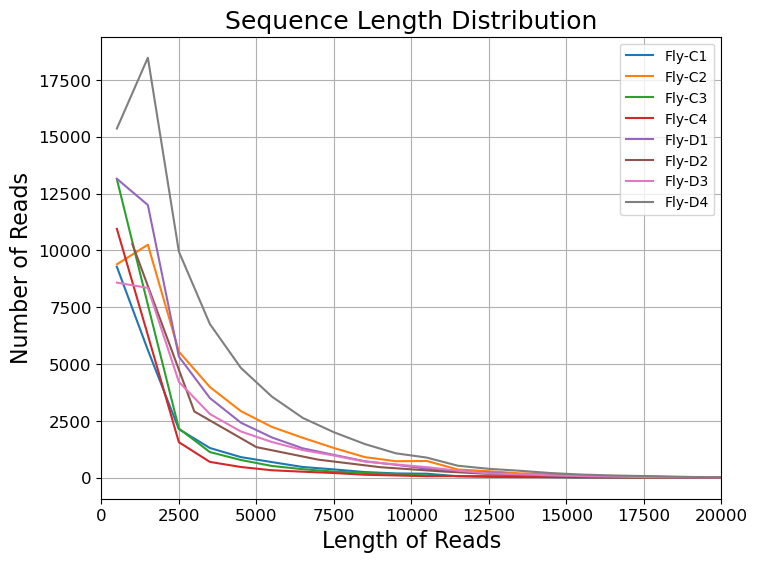

In [55]:
import matplotlib.pyplot as plt

# Data for rural_1_readsubset
rural_1_x = [499, 1499, 2499, 3499, 4499, 5499, 6499, 7499, 8499, 9499, 10499, 11499, 12499, 13499, 14499, 15499, 16499, 17499, 18499, 19499, 20499, 21499, 22499, 23499, 24499, 25499, 26499, 27499, 28499, 29499, 30499, 31499, 32499, 33499, 34209]
rural_1_y = [9281, 5618, 2137, 1308, 907, 688, 472, 366, 250, 189, 176, 61, 61, 40, 29, 8, 8, 9, 6, 2, 2, 4, 0, 0, 0, 2, 0, 2, 1, 0, 0, 0, 0, 0, 1]

# Data for rural_2_readsubset
rural_2_x = [499, 1499, 2499, 3499, 4499, 5499, 6499, 7499, 8499, 9499, 10499, 11499, 12499, 13499, 14499, 15499, 16499, 17499, 18499, 19499, 20499, 21499, 22499, 23499, 24499, 25499, 26499, 27499, 28499, 29499, 30499, 31006]
rural_2_y = [9392, 10253, 5548, 3992, 2931, 2236, 1755, 1308, 906, 727, 736, 361, 287, 192, 180, 93, 79, 52, 38, 21, 20, 12, 10, 5, 2, 6, 2, 2, 0, 1, 2, 1]

# Data for rural_3_readsubset
rural_3_x = [499, 1499, 2499, 3499, 4499, 5499, 6499, 7499, 8499, 9499, 10499, 11499, 12499, 13499, 14499, 15499, 16499, 17499, 18499, 19499, 20499, 21499, 22499, 23499, 24499, 25499, 26499, 27499, 28499, 29499, 30499, 31499, 32499, 33499, 34499, 35499, 36499, 37499, 38499, 39499, 40499, 41499, 42499, 43499, 44499, 45499, 46499, 47499, 48380]
rural_3_y = [13139, 7607, 2164, 1129, 780, 518, 374, 269, 209, 163, 95, 76, 64, 43, 27, 26, 21, 9, 9, 6, 6, 5, 2, 3, 5, 2, 0, 0, 0, 1, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1]

# Data for rural_4_readsubset
rural_4_x = [499, 1499, 2499, 3499, 4499, 5499, 6499, 7499, 8499, 9499, 10499, 11499, 12499, 13499, 14499, 15499, 16499, 17499, 18499, 19499, 20499, 21499, 22499, 23499, 24499, 25499, 26499, 27499, 28454]
rural_4_y = [10952, 6270, 1563, 696, 472, 328, 265, 207, 130, 100, 65, 74, 39, 29, 28, 21, 14, 8, 12, 9, 4, 3, 0, 0, 2, 0, 0, 0, 3]

# Data for urban_1_readsubseta
urban_1_x = [499, 1499, 2499, 3499, 4499, 5499, 6499, 7499, 8499, 9499, 10499, 11499, 12499, 13499, 14499, 15499, 16499, 17499, 18499, 19499, 20499, 21499, 22499, 23499, 24499, 25499, 26499, 27499, 28499, 29499, 30499, 31499, 32499, 33499, 34499, 35340]
urban_1_y = [13156, 12000, 5331, 3507, 2423, 1773, 1292, 1005, 726, 569, 397, 277, 231, 139, 105, 77, 58, 48, 27, 23, 17, 11, 15, 5, 5, 3, 4, 3, 3, 2, 1, 3, 1, 2, 0, 1]

# Data for urban_2_readsubset
urban_2_x = [999, 2999, 4999, 6999, 8999, 10999, 12999, 14999, 16999, 18999, 20999, 22999, 24999, 26999, 28999, 30999, 32999, 34999, 36999, 38999, 40999, 42999, 44999, 46999, 48999, 50999, 52999, 54999, 56999, 58999, 60999, 62999, 64999, 66999, 68999, 70999, 72999, 74999, 76999, 78999, 80999, 82999, 84629]
urban_2_y = [10282, 2914, 1347, 795, 463, 276, 132, 95, 34, 27, 13, 8, 8, 4, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]

# Data for urban_3_readsubset
urban_3_x = [499, 1499, 2499, 3499, 4499, 5499, 6499, 7499, 8499, 9499, 10499, 11499, 12499, 13499, 14499, 15499, 16499, 17499, 18499, 19499, 20499, 21499, 22499, 23499, 24499, 25499, 26499, 27499, 28499, 29499, 30499, 31499, 32499, 33499, 34499, 35499, 36499, 37499, 38499, 39499, 40499, 41499, 42499, 43499, 44499, 45499, 46126]
urban_3_y = [8586, 8353, 4217, 2804, 2035, 1572, 1215, 977, 708, 583, 465, 310, 190, 149, 109, 73, 52, 26, 22, 20, 16, 3, 8, 6, 3, 5, 3, 0, 1, 2, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]

# Data for urban_4_readsubset
urban_4_x = [499, 1499, 2499, 3499, 4499, 5499, 6499, 7499, 8499, 9499, 10499, 11499, 12499, 13499, 14499, 15499, 16499, 17499, 18499, 19499, 20499, 21499, 22499, 23499, 24499, 25499, 26499, 27499, 28499, 29017]
urban_4_y = [15367, 18483, 9950, 6764, 4834, 3570, 2630, 2002, 1482, 1074, 885, 528, 392, 306, 205, 139, 99, 74, 44, 24, 9, 8, 5, 8, 3, 4, 6, 0, 1, 1]

# Plotting
plt.figure(figsize=(8, 6))

# Plot rural_1
plt.plot(rural_1_x, rural_1_y, label='Fly-C1')

# Plot rural_2
plt.plot(rural_2_x, rural_2_y, label='Fly-C2')

# Plot rural_3
plt.plot(rural_3_x, rural_3_y, label='Fly-C3')

# Plot rural_4
plt.plot(rural_4_x, rural_4_y, label='Fly-C4')

# Plot urban_1
plt.plot(urban_1_x, urban_1_y, label='Fly-D1')

# Plot urban_2
plt.plot(urban_2_x, urban_2_y, label='Fly-D2')

# Plot urban_3
plt.plot(urban_3_x, urban_3_y, label='Fly-D3')

# Plot urban_4
plt.plot(urban_4_x, urban_4_y, label='Fly-D4')

# Add labels and title
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Line Plots for Different Samples')
plt.legend()

# Set the font size for axis labels
plt.xlabel('Length of Reads', fontsize=16)  # Adjust the font size as needed
plt.ylabel('Number of Reads', fontsize=16)  # Adjust the font size as needed

# Set the font size for title
plt.title('Sequence Length Distribution', fontsize=18)  # Adjust the font size as needed

# Set the font size for ticks on the x and y axes
plt.xticks(fontsize=12)  # Adjust the font size as needed
plt.yticks(fontsize=12)  # Adjust the font size as needed

# Set the limit for the x-axis
plt.xlim(0, 20000)

# Save the plot as a PNG file
plt.savefig('sequence_length_distribution.png')

# Show plot
plt.grid(True)
plt.show()
